In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from terminal_optimization import hydrogen_objects
from terminal_optimization import hydrogen_defaults
from terminal_optimization import hydrogen_system

# 0. Prepare inputs

In [2]:
startyear = 2018
lifecycle = 10

## 0.1 Generate demand forecast scenario

In [3]:
years = list(range(startyear, startyear+lifecycle))

demand = []
for year in years:
    if year < 2023:
        demand.append(1_000_000)
    else:
        demand.append(2_000_000)

scenario_data={'year': years, 'volume': demand}

# instantiate a commodity objects
lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.lhydrogen_data)
lhydrogen.scenario_data = pd.DataFrame(data=scenario_data)

# Ammonia
hydrogen_defaults.ammonia_data['historic_data'] = []
hydrogen_defaults.ammonia_data['scenario_data'] = []
ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.ammonia_data)

# soybeans
hydrogen_defaults.MCH_data['historic_data'] = []
hydrogen_defaults.MCH_data['scenario_data'] = []
MCH = hydrogen_objects.Commodity(**hydrogen_defaults.MCH_data)

# combine
demand = [lhydrogen, ammonia, MCH]

# plot scenarios 
if False:
    lhydrogen.plot_demand()
    ammonia.plot_demand()
    MCH.plot_demand()

## 0.2 Generate vessels

In [4]:
# instantiate vessels
Smallhydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.smallhydrogen_data)
Largehydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.largehydrogen_data)
Smallammonia = hydrogen_objects.Vessel(**hydrogen_defaults.smallammonia_data)
Largeammonia = hydrogen_objects.Vessel(**hydrogen_defaults.largeammonia_data)
Handysize = hydrogen_objects.Vessel(**hydrogen_defaults.handysize_data)
Panamax = hydrogen_objects.Vessel(**hydrogen_defaults.panamax_data)
VLCC = hydrogen_objects.Vessel(**hydrogen_defaults.vlcc_data)


vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

# 1. Instatiate terminal system

In [5]:
Terminal = hydrogen_system.System(startyear = startyear, 
                         lifecycle = lifecycle, 
                         elements = demand + vessels, 
                         operational_hours = 5840,   # example Wijnand
                         debug=True,
                         storage_type_defaults=hydrogen_defaults.storage_lh2_data)

# 2. Start simulation
Develop terminal given the throughput scenario and investment triggers implemented

In [6]:
Terminal.simulate()


Simulate year: 2018
  Total vessel calls: 54
     Small Hydrogen  calls: 30
     Large Hydrogen calls: 24
     Small ammonia calls: 0
     Large ammonia calls: 0
     Handysize calls: 0
     Panamax calls: 0
     VLCC calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online (@ start of year): inf
     Unloading occupancy planned (@ start of year): inf
     Unloading occupancy online (@ start of year): inf
     waiting time factor (@ start of year): inf
     waiting time occupancy (@ start of year): inf
  *** add Berth to elements
     Berth occupancy planned (after adding ber

     Revenues (demand): 1000000000
     Revenues (throughput): 0
     Revenues (demand): 1000000000
     Revenues (throughput): 0
     Revenues (demand): 1000000000
     Revenues (throughput): 1019999999
     Revenues (demand): 1000000000
     Revenues (throughput): 1019999999
     Revenues (demand): 1000000000
     Revenues (throughput): 1019999999
     Revenues (demand): 2000000000
     Revenues (throughput): 2010000000
     Revenues (demand): 2000000000
     Revenues (throughput): 2010000000
     Revenues (demand): 2000000000
     Revenues (throughput): 2010000000
     Revenues (demand): 2000000000
     Revenues (throughput): 2010000000
     Revenues (demand): 2000000000
     Revenues (throughput): 2010000000
PV: [-7.27800000e+07 -3.59671512e+09 -2.42625718e+08  8.34710041e+08
  8.54458082e+08 -1.11558430e+09  1.77201336e+09  1.70573749e+09
  1.74089454e+09  1.77185120e+09]
NPV: 3651959574.9238625


## Report all elements

In [7]:
if True: 
    for element in Terminal.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__)


Liquid hydrogen

{'historic_data':    year   volume
0  2014  1000000
1  2015  1100000
2  2016  1250000
3  2017  1400000
4  2018  1500000, 'scenario_data':    year   volume
0  2018  1000000
1  2019  1000000
2  2020  1000000
3  2021  1000000
4  2022  1000000
5  2023  2000000
6  2024  2000000
7  2025  2000000
8  2026  2000000
9  2027  2000000, 'handling_fee': 1000, 'smallhydrogen_perc': 30, 'largehydrogen_perc': 70, 'smallammonia_perc': 0, 'largeammonia_perc': 0, 'handysize_perc': 0, 'panamax_perc': 0, 'vlcc_perc': 0, 'name': 'Liquid hydrogen', 'id': 'cd01f92e-5f80-11e9-a142-c8ff2870e0c9'}

Ammonia

{'historic_data': [], 'scenario_data': [], 'handling_fee': 1000, 'smallhydrogen_perc': 0, 'largehydrogen_perc': 0, 'smallammonia_perc': 40, 'largeammonia_perc': 60, 'handysize_perc': 0, 'panamax_perc': 0, 'vlcc_perc': 0, 'name': 'Ammonia', 'id': 'cd022034-5f80-11e9-a6d0-c8ff2870e0c9'}

MCH

{'historic_data': [], 'scenario_data': [], 'handling_fee': 1000, 'smallhydrogen_perc': 0, 'largehydroge

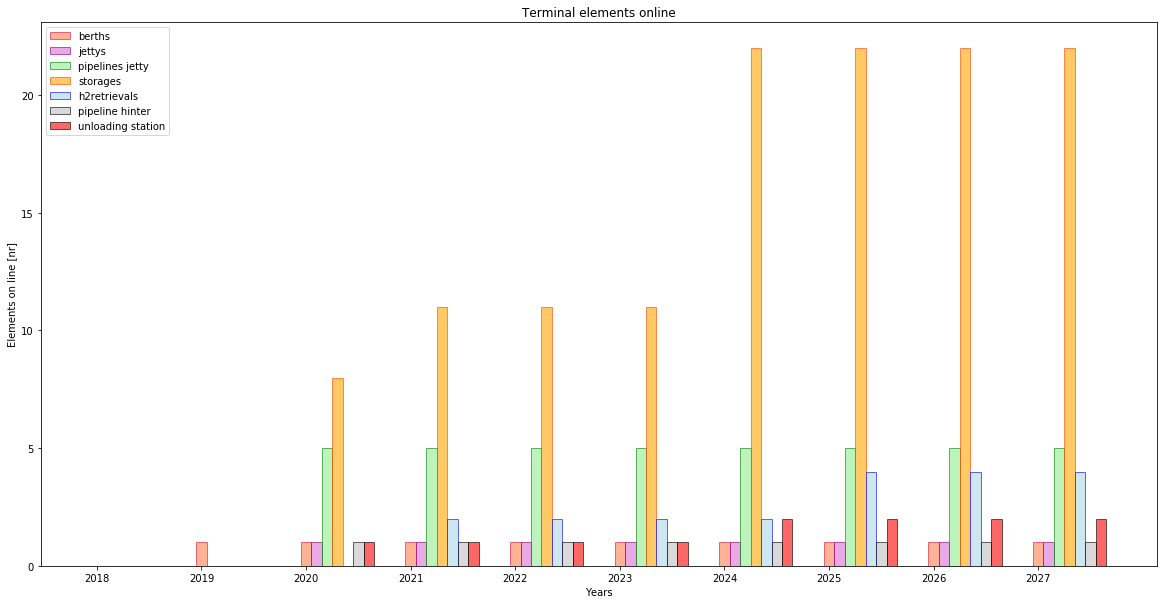

In [8]:
Terminal.terminal_elements_plot()

In [9]:
Terminal.add_cashflow_elements()

(   year         capex  maintenance    insurance        energy        labour  \
 0  2018  7.278000e+07          0.0          0.0  0.000000e+00  0.000000e+00   
 1  2019  4.084740e+09          0.0          0.0  0.000000e+00  0.000000e+00   
 2  2020  1.515160e+09   42364000.0   41312000.0  2.069479e+06  1.812438e+06   
 3  2021  0.000000e+00   58084000.0   56672000.0  1.251703e+08  2.188669e+06   
 4  2022  0.000000e+00   58084000.0   56672000.0  1.251703e+08  2.188669e+06   
 5  2023  5.525040e+09   58084000.0   56672000.0  2.441662e+08  2.188669e+06   
 6  2024  1.456000e+07  113100000.0  111680000.0  2.466630e+08  3.166869e+06   
 7  2025  0.000000e+00  113820000.0  112040000.0  4.878630e+08  3.317362e+06   
 8  2026  0.000000e+00  113820000.0  112040000.0  4.878630e+08  3.317362e+06   
 9  2027  0.000000e+00  113820000.0  112040000.0  4.878630e+08  3.317362e+06   
 
    demurrage    revenues  
 0          0           0  
 1          0           0  
 2          0  1000000000  
 3    

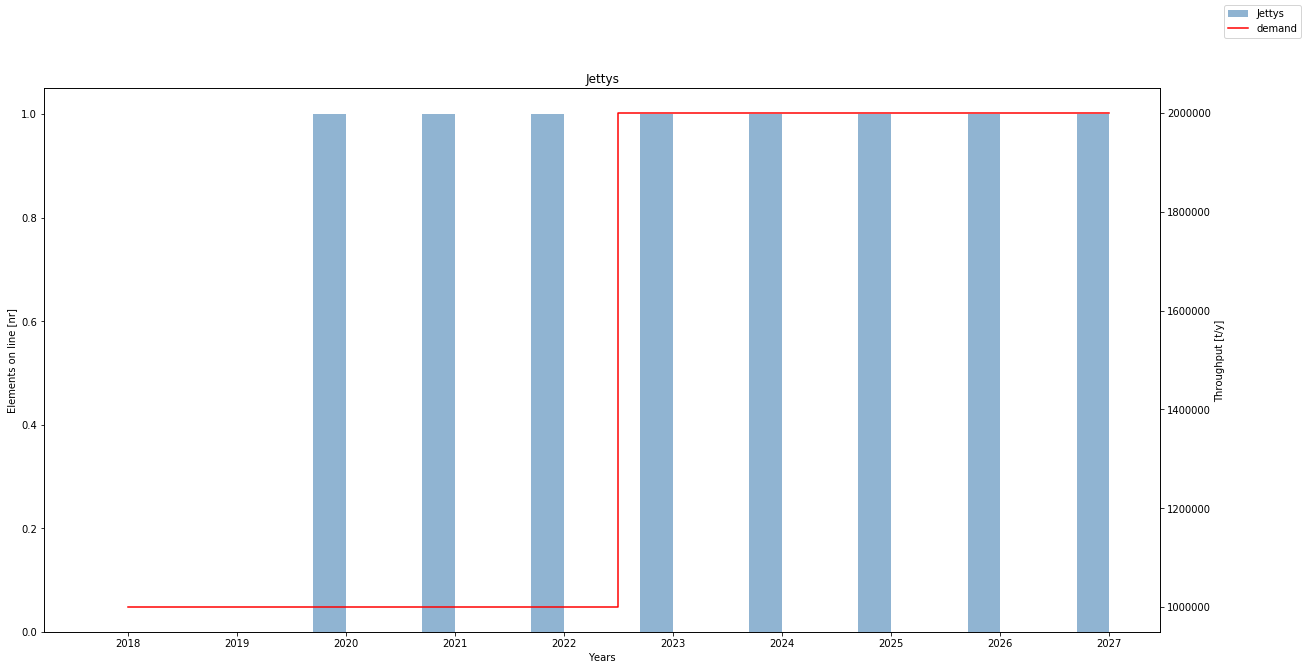

In [10]:
Terminal.terminal_elements_example_plot()

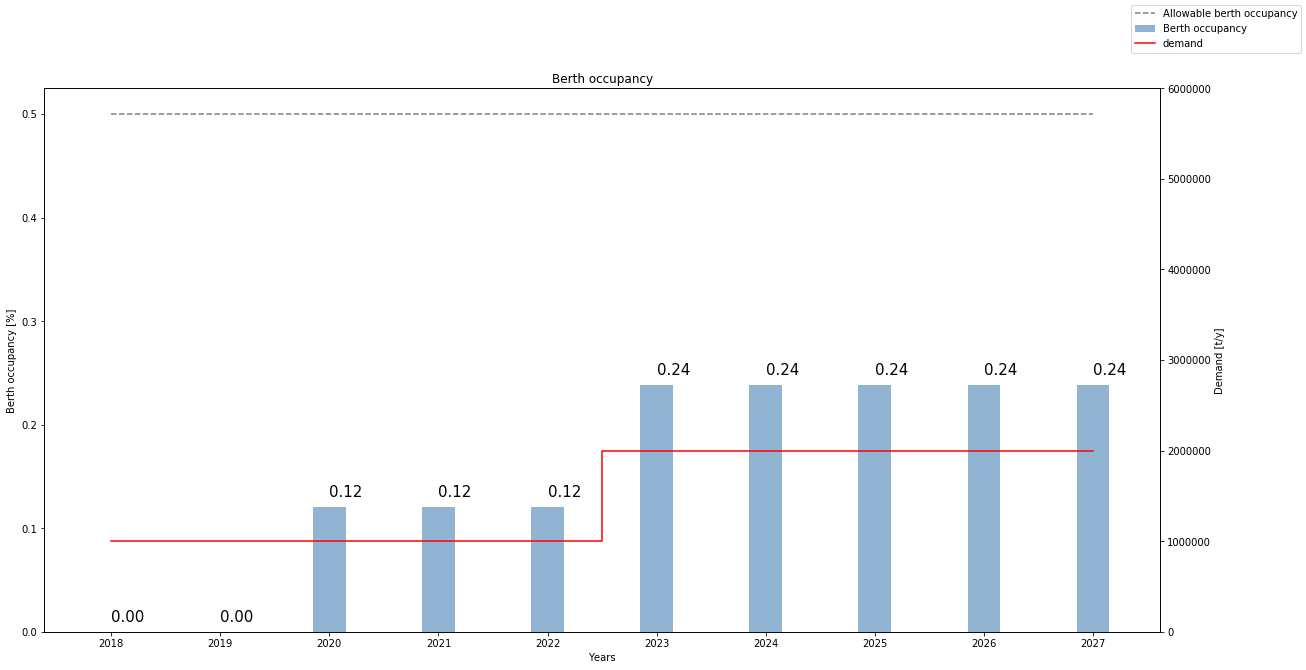

In [11]:
Terminal.terminal_occupancy_example_plot()

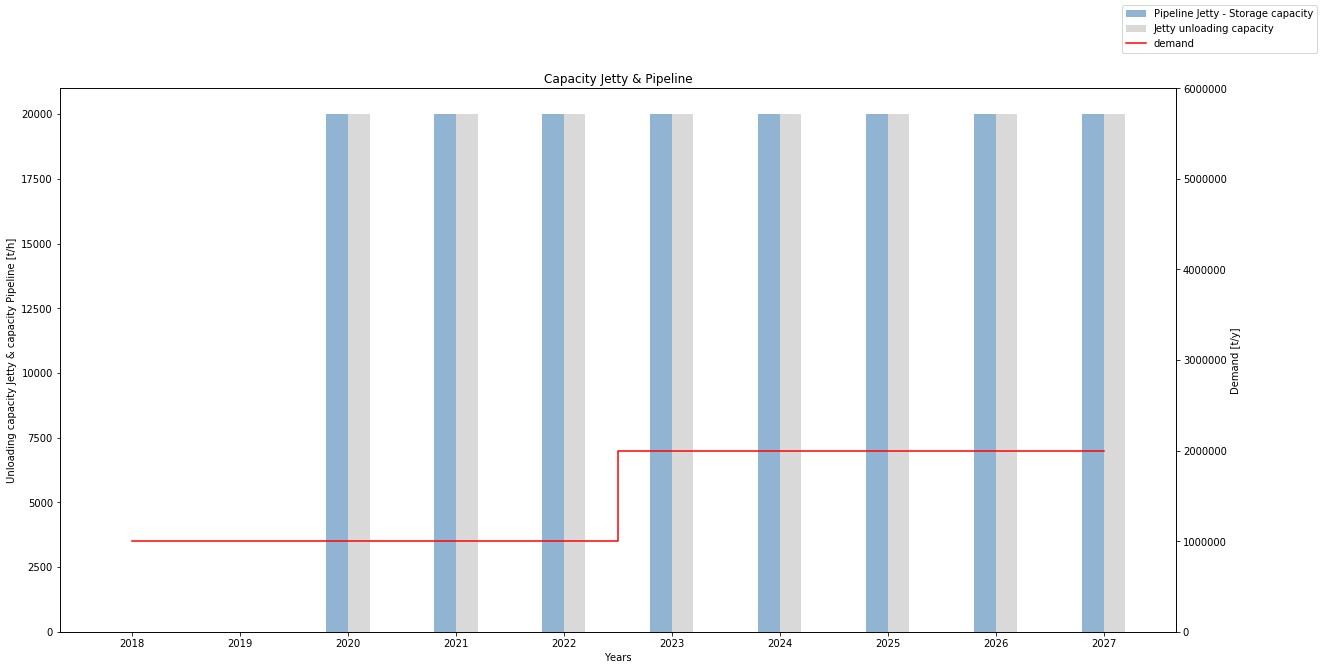

In [12]:
Terminal.terminal_pipeline_plot()

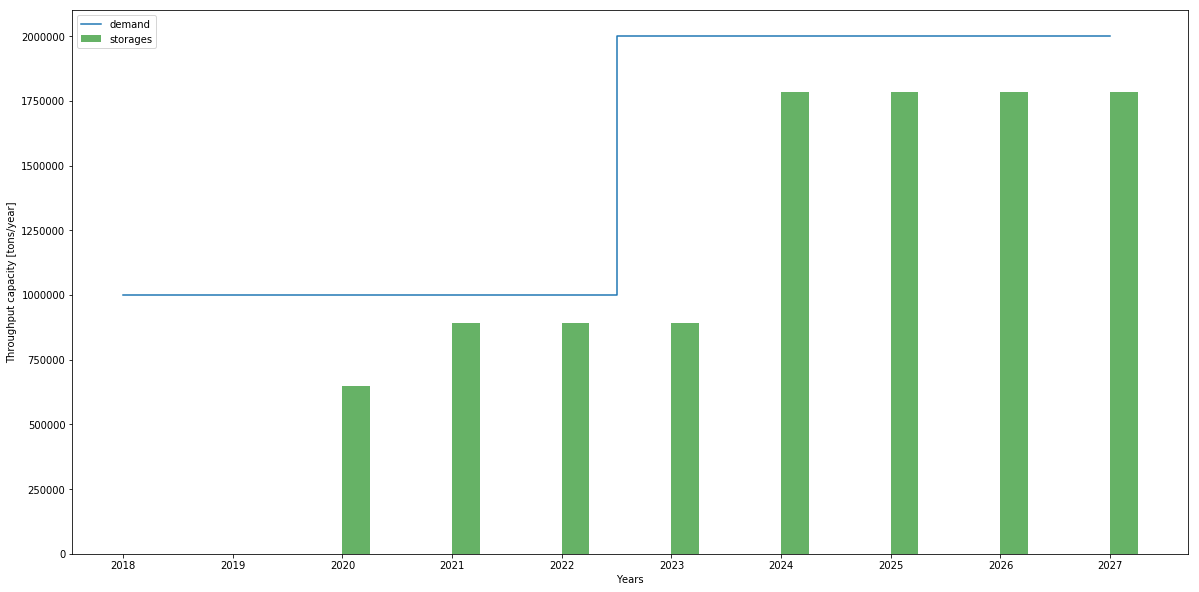

In [13]:
Terminal.terminal_capacity_plot()

In [14]:
# add cash flow information for each of the Terminal elements
cash_flows, cash_flows_WACC_real = Terminal.add_cashflow_elements()

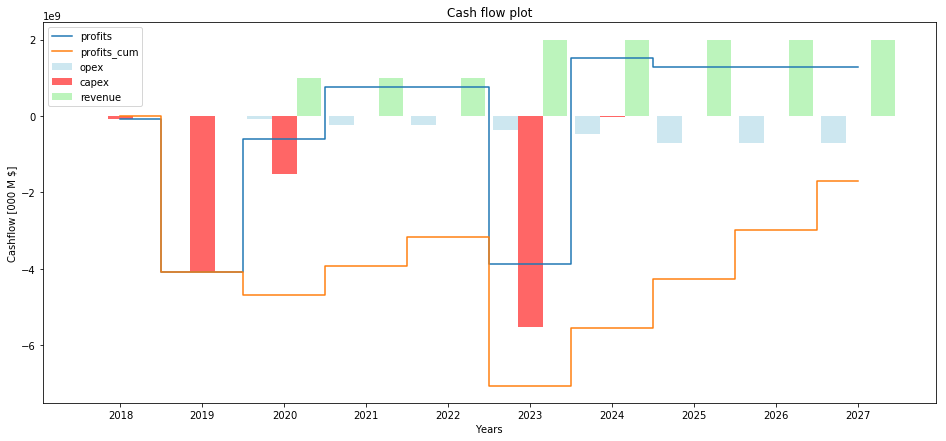

In [15]:
Terminal.cashflow_plot(cash_flows)

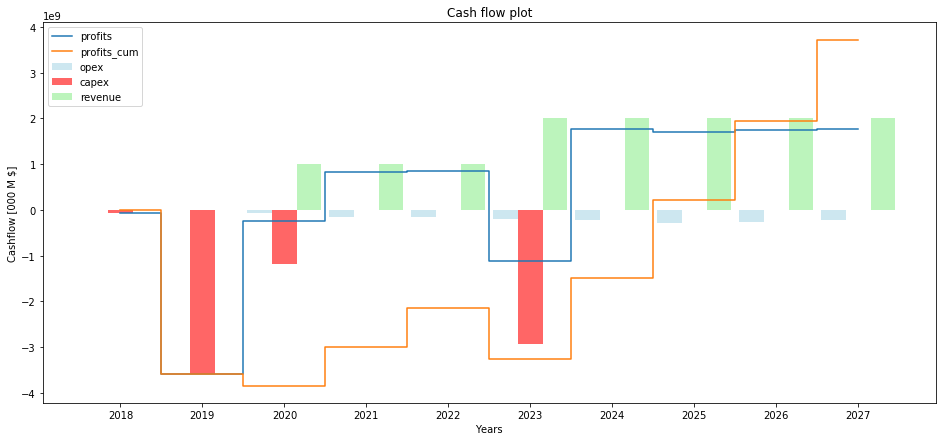

In [16]:
Terminal.cashflow_plot(cash_flows_WACC_real)

## SandBox

In [17]:
Terminal.NPV()

PV: [-7.27800000e+07 -3.59671512e+09 -2.42625718e+08  8.34710041e+08
  8.54458082e+08 -1.11558430e+09  1.77201336e+09  1.70573749e+09
  1.74089454e+09  1.77185120e+09]
NPV: 3651959574.9238625
